# Get images

In [5]:
from PIL import Image
import os

def stitch_images(rgb_path, event_path, hybrid_path, tracked_path, output_filename="stitched_image.png"):
    """
    Reads four images from specified paths, places them side-by-side,
    and saves the combined image.

    Args:
        rgb_path (str): Path to the RGB image.
        event_path (str): Path to the Event image.
        hybrid_path (str): Path to the Hybrid image.
        tracked_path (str): Path to the Tracked image.
        output_filename (str, optional): The name of the output stitched image file.
                                         Defaults to "stitched_image.png".
    """
    image_paths = {
        "RGB": rgb_path,
        "Event": event_path,
        "Hybrid": hybrid_path,
        "Tracked": tracked_path
    }

    images = []
    for name, path in image_paths.items():
        if not os.path.exists(path):
            print(f"Error: Image not found at path for {name}: {path}")
            return
        try:
            img = Image.open(path)
            images.append(img)
        except Exception as e:
            print(f"Error opening image {name} at {path}: {e}")
            return

    # Ensure all images have the same height for consistent stitching
    # You might want to add resizing logic here if heights can vary.
    # For simplicity, this assumes they are the same height or you want to
    # stretch/compress them to a common height.
    if not images:
        print("No images loaded to stitch.")
        return

    # Determine the maximum height among images
    max_height = max(img.height for img in images)

    # Calculate total width
    total_width = sum(img.width for img in images)

    # Create a new blank image with the calculated total width and max height
    stitched_image = Image.new('RGB', (total_width, max_height))

    # Paste images side by side
    x_offset = 0
    for img in images:
        # Resize images to max_height if their heights differ, maintaining aspect ratio
        if img.height != max_height:
            aspect_ratio = img.width / img.height
            new_width = int(max_height * aspect_ratio)
            img = img.resize((new_width, max_height), Image.LANCZOS) # Use LANCZOS for good quality downsampling
        stitched_image.paste(img, (x_offset, 0))
        x_offset += img.width

    # Save the stitched image
    stitched_image.save(output_filename)
    print(f"Stitched image saved as {output_filename}")



In [6]:


rgb_image_path = "path/to/your/RGB.png"
event_image_path = "path/to/your/Event.png"
hybrid_image_path = "path/to/your/Hybrid.png"
tracked_image_path = "path/to/your/Tracked.png"

# Create dummy image files for testing if they don't exist
for path_var, name in zip([rgb_image_path, event_image_path, hybrid_image_path, tracked_image_path],
                            ["RGB", "Event", "Hybrid", "Tracked"]):
    if not os.path.exists(os.path.dirname(path_var)) and os.path.dirname(path_var) != '':
        os.makedirs(os.path.dirname(path_var))
    if not os.path.exists(path_var):
        try:
            # Create a simple dummy image
            dummy_img = Image.new('RGB', (200, 150), color = (255, 0, 0) if name == "RGB" else \
                                                            (0, 255, 0) if name == "Event" else \
                                                            (0, 0, 255) if name == "Hybrid" else \
                                                            (255, 255, 0))
            dummy_img.save(path_var)
            print(f"Created dummy image at: {path_var}")
        except Exception as e:
            print(f"Could not create dummy image at {path_var}: {e}")

# Call the function to stitch the images
stitch_images(rgb_image_path, event_image_path, hybrid_image_path, tracked_image_path, "combined_output.png")

print("\n--- Script finished ---")
print("Remember to replace the dummy paths in the `if __name__ == '__main__':` block with your actual image paths!")

Created dummy image at: path/to/your/RGB.png
Created dummy image at: path/to/your/Event.png
Created dummy image at: path/to/your/Hybrid.png
Created dummy image at: path/to/your/Tracked.png
Stitched image saved as combined_output.png

--- Script finished ---
Remember to replace the dummy paths in the `if __name__ == '__main__':` block with your actual image paths!


# Detetction Metrics

In [7]:
import pandas as pd
import glob

mean_names = ['rgb', 'event']

for mean_name in mean_names:
    csv_files = glob.glob(f"metrics/detection/*{mean_name}.csv")
    dfs = []

    for f in csv_files:
        df = pd.read_csv(f, delimiter=';')

        # Clean column names: strip spaces and lowercase
        df.columns = df.columns.str.strip().str.lower()

        # Check for required columns
        if {'conf', 'class'}.issubset(df.columns):
            dfs.append(df)
        else:
            print(f"⚠️ Skipping {f} — missing 'conf' or 'class' after cleaning. Columns: {list(df.columns)}")

    if not dfs:
        print(f"❌ No valid CSV files found for {mean_name}")
        continue

    all_data = pd.concat(dfs, ignore_index=True)

    # Group and average all other numeric columns
    mean_df = all_data.groupby(['conf', 'class'], as_index=False).mean(numeric_only=True)

    mean_df.to_csv(f"metrics/detection/mean_metrics_{mean_name}.csv", index=False, sep=';')

    print(f"✅ Saved mean file for {mean_name}")



✅ Saved mean file for rgb
✅ Saved mean file for event


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV (semicolon-separated)
df = pd.read_csv('metrics/results_saved/mean_metrics_rgb_event_separated.csv', delimiter=';')

# Compute F1 scores
df['f1_50'] = 2 * (df['p50'] * df['r50']) / (df['p50'] + df['r50'] + 1e-8)
df['f1_75'] = 2 * (df['p75'] * df['r75']) / (df['p75'] + df['r75'] + 1e-8)

# Filter for confidence threshold >= 0.5
df = df[df['conf'] >= 0.04]



# Define colors
colors = {
    ('rgb', 'f1_50'): '#1f77b4',     # Blue
    ('rgb', 'f1_75'): '#2ca02c',     # Green
    ('event', 'f1_50'): '#d62728',   # Red
    ('event', 'f1_75'): '#9467bd',   # Purple
    ('hybrid', 'f1_50'): '#ff7f0e',  # Orange
    ('hybrid', 'f1_75'): '#8c564b'   # Brown
}

# Unique classes
unique_classes = df['class'].unique()

# Plot for each class
for class_id in unique_classes:
    subset_class = df[df['class'] == class_id]
    
    plt.figure()
    
    for data_type in ['rgb', 'event','hybrid']:
        subset = subset_class[subset_class['Type'] == data_type].sort_values('conf')
        if not subset.empty:
            plt.plot(subset['conf'], subset['f1_50'], marker='o', color=colors[(data_type, 'f1_50')], label=f'{data_type} @ IoU=0.5')
            plt.plot(subset['conf'], subset['f1_75'], marker='x', color=colors[(data_type, 'f1_75')], label=f'{data_type} @ IoU=0.75')

    plt.title(f'F1 Score vs Confidence  - Class {"car" if class_id == 1 else "pedestrian"}')

    plt.xlabel('Confidence Threshold')
    plt.ylabel('F1 Score')
    #plt.ylim(0, 0.55 if class_id == 1 else 0.4)
    plt.ylim(0, 0.7 if class_id == 1 else 0.5)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

TypeError: can't multiply sequence by non-int of type 'str'

# Tracking Metrics

In [11]:
import pandas as pd

df = pd.read_csv("metrics/metrics.csv",sep=";")
#df = pd.read_csv("metrics/results_saved/metrics.csv",sep=";")

In [12]:
percent_metrics = ['IDF1', 'IDP', 'IDR', 'Prcn', 'Rcll', 'MOTA', 'MOTP']
int_metrics = ['FP', 'FN', 'IDs', 'GT', 'MT', 'PT', 'ML']

In [13]:
print(df.head())
print(df.columns)

           Sequence    Type  class      IDF1       IDP       IDR      Rcll  \
0  zurich_city_13_a     rgb      0  0.657534  0.872727  0.527473  0.560440   
1  zurich_city_13_a     rgb      1  0.694332  0.666019  0.725159  0.736786   
2  zurich_city_13_a   event      0  0.391111  0.328358  0.483516  0.516484   
3  zurich_city_13_a   event      1  0.751964  0.801435  0.708245  0.716702   
4  zurich_city_13_a  hybrid      0  0.628571  0.897959  0.483516  0.516484   

       Prcn  GT  MT  ...  ML   FP   FN  IDs  FM      MOTA      MOTP  IDt  IDa  \
0  0.927273   3   2  ...   1    4   40    0   3  0.516484  0.317055    1    0   
1  0.676699  12   3  ...   6  333  249    2   3  0.382664  0.179809    0    2   
2  0.350746   3   2  ...   1   87   44    0   1 -0.439560  0.331500    1    0   
3  0.811005  12   2  ...   7  158  268    1   1  0.548626  0.184745    0    1   
4  0.959184   3   2  ...   1    2   44    0   1  0.494505  0.327913    1    0   

   IDm  
0    1  
1    0  
2    1  
3    0  

In [14]:
class_0_rgb = df[(df['Type'] == 'rgb') & (df['class'] == 0)]

class_1_rgb = df[(df['Type'] == 'rgb') & (df['class'] == 1)]

class_0_event = df[(df['Type'] == 'event') & (df['class'] == 0)]

class_1_event = df[(df['Type'] == 'event') & (df['class'] == 1)]

class_0_hybrid = df[(df['Type'] == 'hybrid') & (df['class'] == 0)]

class_1_hybrid = df[(df['Type'] == 'hybrid') & (df['class'] == 1)]

In [15]:
mean_metrics_c0_rgb = class_0_rgb.groupby('Sequence').mean(numeric_only=True)
mean_metrics_c1_rgb = class_1_rgb.groupby('Sequence').mean(numeric_only=True)

mean_metrics_c0_event = class_0_event.groupby('Sequence').mean(numeric_only=True)
mean_metrics_c1_event = class_1_event.groupby('Sequence').mean(numeric_only=True)

mean_metrics_c0_hybrid = class_0_hybrid.groupby('Sequence').mean(numeric_only=True)
mean_metrics_c1_hybrid = class_1_hybrid.groupby('Sequence').mean(numeric_only=True)

In [16]:
summary_class_0 = pd.DataFrame({
    'c0_rgb': class_0_rgb.groupby('Sequence').mean(numeric_only=True).mean(),
    'c0_event': class_0_event.groupby('Sequence').mean(numeric_only=True).mean(),
    'c0_hybrid': class_0_hybrid.groupby('Sequence').mean(numeric_only=True).mean(),
})

summary_class_1 = pd.DataFrame({
    'c1_rgb': class_1_rgb.groupby('Sequence').mean(numeric_only=True).mean(),
    'c1_event': class_1_event.groupby('Sequence').mean(numeric_only=True).mean(),
    'c1_hybrid': class_1_hybrid.groupby('Sequence').mean(numeric_only=True).mean(),
})

In [17]:
metrics_to_display = [ 'IDF1','IDP','Prcn', 'Rcll','IDs','MOTA','MOTP']

In [18]:
print(summary_class_0.loc[metrics_to_display].T)

               IDF1       IDP      Prcn      Rcll       IDs      MOTA  \
c0_rgb     0.487273  0.725660  0.776720  0.422638  1.222222  0.338361   
c0_event   0.274697  0.499894  0.558879  0.251191  1.111111  0.065273   
c0_hybrid  0.411664  0.708217  0.792053  0.358817  2.000000  0.288080   

               MOTP  
c0_rgb     0.262127  
c0_event   0.333587  
c0_hybrid  0.296198  


In [19]:
print(summary_class_1.loc[metrics_to_display].T)

               IDF1       IDP      Prcn      Rcll        IDs      MOTA  \
c1_rgb     0.655526  0.702062  0.742444  0.661828  10.363636  0.421345   
c1_event   0.473628  0.646150  0.737601  0.443606   5.363636  0.268958   
c1_hybrid  0.671559  0.761394  0.799233  0.638194   8.636364  0.476998   

               MOTP  
c1_rgb     0.240044  
c1_event   0.244716  
c1_hybrid  0.232434  


In [20]:
summary_class_0.T

,class,IDF1,IDP,IDR,Rcll,Prcn,GT,MT,PT,ML,FP,FN,IDs,FM,MOTA,MOTP,IDt,IDa,IDm
c0_rgb,0.0,0.487273,0.725660,0.383937,0.422638,0.776720,11.444444,1.555556,4.111111,5.777778,51.666667,307.000000,1.222222,9.666667,0.338361,0.262127,0.888889,1.111111,0.777778
c0_event,0.0,0.274697,0.499894,0.219660,0.251191,0.558879,11.444444,0.333333,2.777778,8.333333,70.888889,452.555556,1.111111,8.666667,0.065273,0.333587,0.666667,0.777778,0.333333
c0_hybrid,0.0,0.411664,0.708217,0.317469,0.358817,0.792053,11.444444,1.000000,4.111111,6.333333,51.444444,354.777778,2.000000,12.333333,0.288080,0.296198,0.888889,1.444444,0.555556


In [21]:
summary_class_1.T

,class,IDF1,IDP,IDR,Rcll,Prcn,GT,MT,PT,ML,FP,FN,IDs,FM,MOTA,MOTP,IDt,IDa,IDm
c1_rgb,1.0,0.655526,0.702062,0.625142,0.661828,0.742444,29.909091,7.090909,11.000000,11.818182,622.818182,790.181818,10.363636,55.181818,0.421345,0.240044,5.090909,6.454545,3.181818
c1_event,1.0,0.473628,0.646150,0.390285,0.443606,0.737601,29.909091,1.090909,11.363636,17.454545,339.818182,1391.636364,5.363636,36.090909,0.268958,0.244716,4.363636,4.363636,3.454545
c1_hybrid,1.0,0.671559,0.761394,0.607118,0.638194,0.799233,29.909091,5.272727,12.090909,12.545455,401.727273,852.636364,8.636364,48.181818,0.476998,0.232434,4.636364,5.636364,3.000000


# H5 files

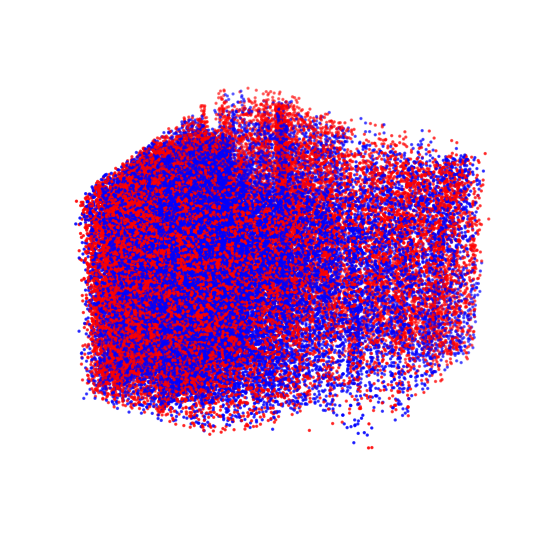

In [107]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load a slice of the event data
with h5py.File("data/dsec/test/interlaken_00_d/events.h5", "r") as f:
    p = f["events/p"][:1000000]  # polarities
    x = f["events/x"][:1000000]
    y = f["events/y"][:1000000]
    t = f["events/t"][:1000000]  # timestamps in microseconds

# Normalize timestamps to milliseconds and subtract the min to start at zero
t_ms = (t - t.min()) / 1000.0

# Optional: downsample to reduce density
sampling_mask = np.random.rand(len(t_ms)) < 0.1
x = x[sampling_mask]
y = y[sampling_mask]
t_ms = t_ms[sampling_mask]
p = p[sampling_mask]

# Create 3D scatter plot (like sparse voxel cube)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
# OPTIONAL: Hide axis lines (spines)


colors = np.where(p == 1, 'red', 'blue')
ax.scatter(x, y, t_ms, c=colors, s=2)


# Hide axis values and ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")

ax.grid(False)
ax.set_axis_off()


plt.show()
